# Table of Contents <a class = "anchor" id = "toc"></a>
* [Data Importation](#data_impo)
* [Data Preprocessing](#preprocessing)
* [Data Cleaning](#data_clean)
* [Feature Engineering](#featureeng)
* [Classification Models](#models)
* [Evaluation](#evaluation)

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
nltk.download('opinion_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from tqdm import tqdm
from gensim.models import Word2Vec

from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report, auc
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.models import Model

from sentence_transformers import SentenceTransformer
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import emoji
import langid
import regex
import string

import re
from tqdm import tqdm
import regex

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/catarinasilva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Importation <a class = "anchor" id = "data_impo"></a>
[Back to the Table of Contents](#toc)

In [2]:
%%time
airbnb_train = pd.read_excel('../data/train.xlsx')
airbnb_train_reviews = pd.read_excel('../data/train_reviews.xlsx')
airbnb_test = pd.read_excel('../data/test.xlsx')
airbnb_test_reviews = pd.read_excel('../data/test_reviews.xlsx')

CPU times: user 7.65 s, sys: 108 ms, total: 7.76 s
Wall time: 7.82 s


In [3]:
airbnb_train_reviews['word_count']  = airbnb_train_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
airbnb_train_reviews.dropna(subset=['comments'], inplace=True)
airbnb_test_reviews['word_count']  = airbnb_test_reviews['comments'].apply(lambda x: len(str(x).split(" ")))
airbnb_test_reviews.dropna(subset=['comments'], inplace=True)

In [4]:
airbnb_train.head(2)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1


In [5]:
airbnb_train_reviews.head(2)

,index,comments,word_count
0,1,this is a very cozy and comfortable house to s...,28
1,1,good<br/>,1


In [6]:
airbnb_test.head(2)

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...


In [7]:
airbnb_test_reviews.head(2)

,index,comments,word_count
0,1,Thank you very much Antonio ! All has been per...,33
1,1,Very nice appartment in the old town of Lissab...,41


In [8]:
print(f"The data frame airbnb_train has : {len(airbnb_train)} rows")
print(f"The data frame airbnb_train_reviews has : {len(airbnb_train_reviews)} rows")
print()
print(f"The data frame airbnb_test has : {len(airbnb_test)} rows")
print(f"The data frame airbnb_test_reviews has : {len(airbnb_test_reviews)} rows")

The data frame airbnb_train has : 6248 rows
The data frame airbnb_train_reviews has : 361279 rows

The data frame airbnb_test has : 695 rows
The data frame airbnb_test_reviews has : 41866 rows


# Data Preprocessing <a class = "anchor" id = "preprocessing"></a>
[Back to the Table of Contents](#toc)

### Lowercasing

In [9]:
def lowercasing(text_list):
    updates = []
    
    for text in tqdm(text_list):
        # Lowercase text
        text = text.lower()
        
        # Remove unnecessary tags
        text = re.sub(r"<[^>]+>", " ", text)
        
        
        # Remove all non-alphabetic characters (including underscores and digits)
        text = regex.sub(r"[^\p{L}\s]", " ", text)  # \s is for space to preserve spacing between words
        # Remove 'x' and 'd' when they appear alone
        text = re.sub(r"(^|\s)(x|d)(\s|$)", " ", text)
        text = regex.sub(r"\s+", " ", text)  # Replace multiple spaces with a single space
        
        updates.append(text.strip())  # Strip leading/trailing spaces
    
    return updates

### Train 

#### Comments

In [10]:
lowercased_train_reviews = lowercasing(airbnb_train_reviews['comments'])

100%|████████████████████████████████| 361279/361279 [00:08<00:00, 40235.38it/s]


In [11]:
airbnb_train_reviews['comments'][17]

'Everything is correct, like the photos said. But it is important to know that the kitchen is close from 22 a.p. till 8 a.m.<br/>Regards.'

In [12]:
lowercased_train_reviews[17]

'everything is correct like the photos said but it is important to know that the kitchen is close from a p till a m regards'

#### Property details

In [13]:
lowercased_train_description = lowercasing(airbnb_train['description'])

100%|████████████████████████████████████| 6248/6248 [00:00<00:00, 15647.77it/s]


In [14]:
lowercased_train_host = lowercasing(airbnb_train['host_about'])

100%|████████████████████████████████████| 6248/6248 [00:00<00:00, 25919.96it/s]


In [15]:
airbnb_train['description'][1]

'O meu espaço fica perto de Parque Eduardo VII, Saldanha, estefanea, IST, Nova university ,. O meu espaço é bom para aventuras individuais.'

In [16]:
lowercased_train_description[1]

'o meu espaço fica perto de parque eduardo vii saldanha estefanea ist nova university o meu espaço é bom para aventuras individuais'

In [17]:
airbnb_train['host_about'][17]

'Cool&Easy.\nGoing to the beach minded'

In [18]:
lowercased_train_host[17]

'cool easy going to the beach minded'

### Test

#### Comments

In [19]:
lowercased_test_reviews = lowercasing(airbnb_test_reviews['comments'])

100%|██████████████████████████████████| 41866/41866 [00:01<00:00, 40132.91it/s]


In [20]:
airbnb_test_reviews['comments'][12]

"The flat is a lovely space with everything you need and some lovely old character features. Its centrally located but still far enough away from the hubbub of the barrio. They were kind enough to let us shelter there for a few hours until our flight left. _x000D_<br/>Book this one it's perfect shame the weather was so awful. "

In [21]:
lowercased_test_reviews[12]

'the flat is a lovely space with everything you need and some lovely old character features its centrally located but still far enough away from the hubbub of the barrio they were kind enough to let us shelter there for a few hours until our flight left book this one it s perfect shame the weather was so awful'

#### Property details

In [22]:
lowercased_test_description = lowercasing(airbnb_test['description'])

100%|██████████████████████████████████████| 695/695 [00:00<00:00, 14449.14it/s]


In [23]:
lowercased_test_host = lowercasing(airbnb_test['host_about'])

100%|██████████████████████████████████████| 695/695 [00:00<00:00, 23554.37it/s]


In [24]:
airbnb_test['description'][4]

'Se procura umas férias perto da praia, casino e  outras atracções turísticas, escolha esta agradável casa, com um pitoresco pátio, onde poderá ler um livro, descansar, ou ainda encomendar uma deliciosa prova gastronómica ao anfitrião. Experimente<br /><br /><b>License number</b><br />86364/AL'

In [25]:
lowercased_test_description[4]

'se procura umas férias perto da praia casino e outras atracções turísticas escolha esta agradável casa com um pitoresco pátio onde poderá ler um livro descansar ou ainda encomendar uma deliciosa prova gastronómica ao anfitrião experimente license number al'

In [26]:
airbnb_test['host_about'][3]

':)'

In [27]:
lowercased_test_host[3]

''

## Detect review's languages

In [28]:
def detect_language(text):
    try:
        # Primary language detection with langdetect
        prim_language = detect(text)
        # Secondary language detection with langid
        sec_language, confidence = langid.classify(text)
        if confidence > 0.85:  # Threshold to determine which language to choose
            return sec_language
        return prim_language
    except Exception as e:
        return 'unknown'

### Train

#### Comments

In [29]:
train_reviews = pd.read_csv('../data/reviews_language/airbnb_train_reviews_languages.csv')
train_reviews.drop('Unnamed: 0',axis=1, inplace=True)

In [30]:
train_reviews.head()

,comments,language
0,this is a very cozy and comfortable house to s...,en
1,good,en
2,my first hostel experience and all i have to s...,en
3,das hostel war neu und deshalb funktionierte a...,de
4,it was fine for a dorm but i think for the peo...,en


In [31]:
train_reviews[train_reviews['language'] == 'en']

,comments,language
0,this is a very cozy and comfortable house to s...,en
1,good,en
2,my first hostel experience and all i have to s...,en
4,it was fine for a dorm but i think for the peo...,en
5,our stay in lisbon tip hostel was very good th...,en
...,...,...
360326,ana s place is just what you need for a quick ...,en
360330,definetly good location apartment was cozy and...,en
360331,the location was perfect the apartment was ver...,en
360332,ana s place is exactly as described and even b...,en


In [32]:
unknown_train_reviews = train_reviews[train_reviews['language'] == 'unknown']

In [33]:
unknown_train_reviews['comments'].value_counts()

Series([], Name: count, dtype: int64)

In [34]:
train_reviews.drop(unknown_train_reviews.index, inplace= True)
train_reviews['language'].value_counts()

language
en       233052
fr        53363
pt        22493
es        19293
de        14106
it         5988
nl         3610
ko         1672
ru         1509
zh-cn       909
pl          571
da          481
ca          398
ro          388
sv          385
no          341
cs          294
af          250
fi          191
hu          125
ja          108
he           91
cy           77
so           67
lt           67
tr           56
hr           54
sl           52
sk           49
el           49
uk           44
tl           38
id           33
lv           31
et           30
sw           24
zh-tw        14
bg           11
ar            9
sq            5
vi            5
mk            1
ur            1
zh            1
Name: count, dtype: int64

#### Property details

In [35]:
lowercased_train_host = pd.read_csv('../data/train_property(lower + language)/lowercased_train_host.csv')
lowercased_train_host.drop('Unnamed: 0',axis=1, inplace=True)

In [36]:
lowercased_train_description = pd.read_csv('../data/train_property(lower + language)/lowercased_train_description.csv')
lowercased_train_description.drop('Unnamed: 0',axis=1, inplace=True)

In [37]:
train_property = pd.read_csv('../data/train_property.csv')
train_property.drop('Unnamed: 0',axis=1, inplace=True)

In [38]:
train_property = lowercased_train_description.join(lowercased_train_host)

In [39]:
train_property['index']= airbnb_train['index']
train_property.head()

,description,description_language,host_about,host_language,index
0,this is a shared mixed room in our hostel with...,en,alojamento local registro al,es,1
1,o meu espaço fica perto de parque eduardo vii ...,pt,i am friendly host and i will try to always be...,en,2
2,trafaria s house is a cozy and familiar villa ...,en,i am a social person liking to communicate rea...,en,3
3,apartamento charmoso no chiado entre o largo d...,pt,hello i m portuguese and i love to meet people...,en,4
4,joli appartement en bordure de mer min a pied ...,fr,nous sommes une famille avec deux enfants de e...,fr,5


In [40]:
train_property[train_property['host_language'] == 'unknown']

,description,description_language,host_about,host_language,index
18,the lovely casa do sobral is located in the li...,en,NaN,unknown,19
85,apartment has bedrooms a living room a fitted ...,en,NaN,unknown,86
92,other things to note for your information we a...,en,NaN,unknown,93
110,quarto individual acolhedor com mesa de trabal...,pt,NaN,unknown,111
185,bica apartments is located in one of the most ...,en,NaN,unknown,186
...,...,...,...,...,...
5553,duplex in the heart of old lisbon in alfama on...,en,NaN,unknown,5554
5792,apartment with m consisting of bedrooms living...,en,NaN,unknown,5793
5942,a águamel é uma casa de finais do séc xix que ...,pt,NaN,unknown,5943
5955,brand new studio right in the heart of lisbon ...,en,NaN,unknown,5956


In [41]:
train_property.loc[(train_property['host_language'] == 'unknown') & (train_property['host_about'].str.strip() == ''),\
'host_about'] = "no description provided"

In [42]:
train_property[train_property['host_language'] == 'unknown']

,description,description_language,host_about,host_language,index
18,the lovely casa do sobral is located in the li...,en,NaN,unknown,19
85,apartment has bedrooms a living room a fitted ...,en,NaN,unknown,86
92,other things to note for your information we a...,en,NaN,unknown,93
110,quarto individual acolhedor com mesa de trabal...,pt,NaN,unknown,111
185,bica apartments is located in one of the most ...,en,NaN,unknown,186
...,...,...,...,...,...
5553,duplex in the heart of old lisbon in alfama on...,en,NaN,unknown,5554
5792,apartment with m consisting of bedrooms living...,en,NaN,unknown,5793
5942,a águamel é uma casa de finais do séc xix que ...,pt,NaN,unknown,5943
5955,brand new studio right in the heart of lisbon ...,en,NaN,unknown,5956


#### saving  the results

### Test

#### Comments

In [43]:
test_reviews = pd.read_csv('../data/reviews_language/airbnb_test_reviews_languages.csv')
test_reviews.drop('Unnamed: 0',axis=1, inplace=True)

In [44]:
test_reviews.head()

,comments,language
0,thank you very much antonio all has been perfe...,en
1,very nice appartment in the old town of lissab...,en
2,when travelling we re looking for kids friendl...,en
3,we ve been in lisbon in march adults and child...,en
4,our host antonio was very helpful with informa...,en


In [45]:
unknown_test_reviews = test_reviews[test_reviews['language'] == 'unknown']

In [46]:
unknown_test_reviews['comments'].value_counts()

Series([], Name: count, dtype: int64)

In [47]:
unknown_test_reviews

,comments,language
1077,NaN,unknown
1174,NaN,unknown
1890,NaN,unknown
2166,NaN,unknown
2717,NaN,unknown
...,...,...
40526,NaN,unknown
41047,NaN,unknown
41128,NaN,unknown
41648,NaN,unknown


#### saving the results

#### Property details

In [48]:
lowercased_test_description = pd.read_csv('../data/test_property(lower + language) /lowercased_test_description.csv')
lowercased_test_description.drop('Unnamed: 0',axis=1, inplace=True)

In [49]:
lowercased_test_host = pd.read_csv('../data/test_property(lower + language) /lowercased_test_host.csv')
lowercased_test_host.drop('Unnamed: 0',axis=1, inplace=True)

In [50]:
test_property = pd.read_csv('../data/test_property.csv')
test_property.drop('Unnamed: 0',axis=1, inplace=True)

In [51]:
test_property = lowercased_test_description.join(lowercased_test_host)

In [52]:
test_property['index']= airbnb_test['index']
test_property.head()

,description,description_language,host_about,host_language,index
0,the space apartment located in the historic ce...,en,gosto de viajar de conhecer pessoas gosto de r...,pt,1
1,important in response to covid this property h...,en,we are the be home team you can count on us to...,en,2
2,bright beautiful and spacious this four bedroo...,en,hi there we re guestready a professional prope...,en,3
3,charming apartment close to the bay of cascais...,en,NaN,unknown,4
4,se procura umas férias perto da praia casino e...,pt,bem vindos a portugal adoro o meu país mas tam...,pt,5


In [53]:
test_property[test_property['host_language'] == 'unknown']

,description,description_language,host_about,host_language,index
3,charming apartment close to the bay of cascais...,en,NaN,unknown,4
32,temos a descrição do anúncio em vários idiomas...,pt,NaN,unknown,33
102,this is the most adorable and sweet apartment ...,en,NaN,unknown,103
106,studio in the heart of old lisbon in alfama on...,en,NaN,unknown,107
351,temos a descrição do anúncio em português engl...,pt,NaN,unknown,352
364,the space águamel sintra is a family run bouti...,en,NaN,unknown,365
527,charming apartment in the historical village o...,en,NaN,unknown,528
559,em piso térreo todo mobilado cozinha rústica c...,pt,NaN,unknown,560
605,o meu espaço fica perto de hotel cr chiado ros...,pt,NaN,unknown,606
627,sailing and sleeping on board is one of the ex...,en,NaN,unknown,628


In [54]:
test_property.loc[(test_property['host_language'] == 'unknown') & (test_property['host_about'].str.strip() == ''),\
'host_about'] = "no description provided"

In [55]:
test_property[test_property['host_language'] == 'unknown']

,description,description_language,host_about,host_language,index
3,charming apartment close to the bay of cascais...,en,NaN,unknown,4
32,temos a descrição do anúncio em vários idiomas...,pt,NaN,unknown,33
102,this is the most adorable and sweet apartment ...,en,NaN,unknown,103
106,studio in the heart of old lisbon in alfama on...,en,NaN,unknown,107
351,temos a descrição do anúncio em português engl...,pt,NaN,unknown,352
364,the space águamel sintra is a family run bouti...,en,NaN,unknown,365
527,charming apartment in the historical village o...,en,NaN,unknown,528
559,em piso térreo todo mobilado cozinha rústica c...,pt,NaN,unknown,560
605,o meu espaço fica perto de hotel cr chiado ros...,pt,NaN,unknown,606
627,sailing and sleeping on board is one of the ex...,en,NaN,unknown,628


#### saving the results

## Checking if we have NaNs

In [56]:
print(train_reviews.isna().sum(), end = '\n\n')
print(lowercased_train_description.isna().sum(), end = '\n\n')
print(lowercased_train_host.isna().sum(), end = '\n\n')
print(test_reviews.isna().sum(), end = '\n\n')
print(lowercased_test_description.isna().sum(), end = '\n\n')
print(lowercased_test_host.isna().sum())

comments    1
language    0
dtype: int64

description             0
description_language    0
dtype: int64

host_about       79
host_language     0
dtype: int64

comments    128
language      0
dtype: int64

description             0
description_language    0
dtype: int64

host_about       10
host_language     0
dtype: int64


In [57]:
train_reviews[train_reviews.isna().any(axis=1)]

,comments,language
358704,NaN,en


In [58]:
train_reviews.dropna(inplace=True)

In [59]:
lowercased_train_host[lowercased_train_host.isna().any(axis=1)]

,host_about,host_language
18,NaN,unknown
85,NaN,unknown
92,NaN,unknown
110,NaN,unknown
185,NaN,unknown
...,...,...
5553,NaN,unknown
5792,NaN,unknown
5942,NaN,unknown
5955,NaN,unknown


In [60]:
lowercased_train_host.fillna('empty', inplace=True)

In [61]:
lowercased_test_host.fillna('empty', inplace=True)

In [62]:
print(train_reviews.isna().sum(), end = '\n\n')
print(lowercased_train_description.isna().sum(), end = '\n\n')
print(lowercased_train_host.isna().sum(), end = '\n\n')
print(test_reviews.isna().sum(), end = '\n\n')
print(lowercased_test_description.isna().sum(), end = '\n\n')
print(lowercased_test_host.isna().sum())

comments    0
language    0
dtype: int64

description             0
description_language    0
dtype: int64

host_about       0
host_language    0
dtype: int64

comments    128
language      0
dtype: int64

description             0
description_language    0
dtype: int64

host_about       0
host_language    0
dtype: int64


# Data Cleaning <a class = "anchor" id = "data_clean"></a>
[Back to the Table of Contents](#toc)

In [63]:
# stopwords for various languages
stopwords_dict = {
    'en': set(stopwords.words('english')),
    'fr': set(stopwords.words('french')),
    'pt': set(stopwords.words('portuguese')),
    'es': set(stopwords.words('spanish')),
    'de': set(stopwords.words('german')),
    'it': set(stopwords.words('italian')),
    'nl': set(stopwords.words('dutch')),
    'ru': set(stopwords.words('russian'))
}

# Load lemmatizers for different languages
nlp_fr = spacy.load("fr_core_news_sm")  # French
nlp_es = spacy.load("es_core_news_sm")  # Spanish
nlp_de = spacy.load("de_core_news_sm")  # German
nlp_it = spacy.load("it_core_news_sm")  # Italian
nlp_nl = spacy.load("nl_core_news_sm")  # Dutch
nlp_pt = spacy.load("pt_core_news_sm")  # Portuguese
nlp_ru = spacy.load("ru_core_news_sm")  # Russian

lemmatizers_dict = {
    'en': WordNetLemmatizer(),  # English uses WordNetLemmatizer from NLTK
    'fr': nlp_fr,
    'es': nlp_es,
    'de': nlp_de,
    'it': nlp_it,
    'nl': nlp_nl,
    'pt': nlp_pt,
    'ru': nlp_ru
}

In [64]:
def clean_text(text, language, stopwords_dict, lemmatizers_dict):
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Retrieve the appropriate stopwords and lemmatizer for the language
    stopwords_set = stopwords_dict.get(language, set())
    lemmatizer = lemmatizers_dict.get(language, None)

    # Remove stopwords
    if stopwords_set:
        tokens = [word for word in tokens if word.lower() not in stopwords_set]

    # Lemmatize
    if lemmatizer:
        if isinstance(lemmatizer, WordNetLemmatizer):
            tokens = [lemmatizer.lemmatize(word) for word in tokens]
        else:
            doc = lemmatizer(" ".join(tokens))
            tokens = [token.lemma_ for token in doc]

    # Join tokens back to string
    text = " ".join(tokens)
    return text

def clean_column(df, column_name, language_column, cleaned_column_name, stopwords_dict, lemmatizers_dict):
    tqdm.pandas()
    # Employ the previous function to the specific column
    df[cleaned_column_name] = df.progress_apply(lambda row: clean_text(row[column_name], row[language_column], stopwords_dict, lemmatizers_dict), 
                                                axis = 1)
    return df

#### Comments

In [68]:
train_reviews = clean_column(train_reviews, 'comments', 'language', 'cleaned_comments', stopwords_dict, lemmatizers_dict)
train_reviews

100%|██████████████████████████████████| 360335/360335 [11:58<00:00, 501.54it/s]


,comments,language,cleaned_comments
0,this is a very cozy and comfortable house to s...,en,cozy comfortable house stay never worry safety...
1,good,en,good
2,my first hostel experience and all i have to s...,en,first hostel experience say pretty hard beat p...
3,das hostel war neu und deshalb funktionierte a...,de,hostel neu deshalb funktionieren tadellos schn...
4,it was fine for a dorm but i think for the peo...,en,fine dorm think people staying far le bathroom...
...,...,...,...
360331,the location was perfect the apartment was ver...,en,location perfect apartment close airport right...
360332,ana s place is exactly as described and even b...,en,ana place exactly described even better easy c...
360333,a ana foi muito atenciosa e preocupou se com o...,pt,ana atencioso preocupar conforto durante todo ...
360334,no wifi nor answer the wifi can t be connected...,en,wifi answer wifi connected nobody answered lit...


#### saving the results

#### Property details - description

#### saving the results

#### Property details - host

#### saving the results

#### Importing the cleaned data

In [70]:
train_reviews = pd.read_csv('../data/cleaned/airbnb_train_reviews_cleaned.csv')
train_description = pd.read_csv('../data/cleaned/train_description_cleaned.csv')
train_host = pd.read_csv('../data/cleaned/train_host_cleaned.csv')

train_reviews.drop('Unnamed: 0', axis=1, inplace=True)
train_description.drop('Unnamed: 0', axis=1, inplace=True)
train_host.drop('Unnamed: 0', axis=1, inplace=True)

In [67]:
test_reviews = pd.read_csv('../data/cleaned/airbnb_test_reviews_cleaned.csv')
test_description = pd.read_csv('../data/cleaned/test_description_cleaned.csv')
test_host = pd.read_csv('../data/cleaned/test_host_cleaned.csv')

test_reviews.drop('Unnamed: 0', axis=1, inplace=True)
test_description.drop('Unnamed: 0', axis=1, inplace=True)
test_host.drop('Unnamed: 0', axis=1, inplace=True)

#### checkinh again for Nan values

In [71]:
print(train_reviews.isna().sum(), end = '\n\n')
print(train_description.isna().sum(), end = '\n\n')
print(train_host.isna().sum(), end = '\n\n')
print(test_reviews.isna().sum(), end = '\n\n')
print(test_description.isna().sum(), end = '\n\n')
print(test_host.isna().sum())

comments             0
language             0
cleaned_comments    78
dtype: int64

description             0
description_language    0
cleaned_description     0
dtype: int64

host_about       0
host_language    0
cleaned_host     2
dtype: int64

comments            128
language              0
cleaned_comments    142
dtype: int64

description             0
description_language    0
cleaned_description     0
dtype: int64

host_about       0
host_language    0
cleaned_host     0
dtype: int64


In [72]:
train_host[train_host.isna().any(axis=1)]

,host_about,host_language,cleaned_host
372,s,en,NaN
2981,a,en,NaN


In [73]:
train_host['cleaned_host'].fillna('empty', inplace = True)

In [74]:
test_reviews[test_reviews.isna().any(axis=1)]

,comments,language,cleaned_comments
1077,NaN,unknown,NaN
1174,NaN,unknown,NaN
1890,NaN,unknown,NaN
2166,NaN,unknown,NaN
2717,NaN,unknown,NaN
...,...,...,...
40526,NaN,unknown,NaN
41047,NaN,unknown,NaN
41128,NaN,unknown,NaN
41648,NaN,unknown,NaN


In [75]:
test_reviews.dropna(inplace=True)

In [76]:
train_reviews[train_reviews.isna().any(axis=1)]

,comments,language,cleaned_comments
26,you have to be there,en,NaN
316,i,en,NaN
4675,o,en,NaN
7771,a,en,NaN
20266,все хорошо,ru,NaN
...,...,...,...
326702,a,en,NaN
339058,a,en,NaN
343018,a,en,NaN
346698,as before,en,NaN


In [77]:
train_reviews.dropna(inplace=True)

In [78]:
print(train_reviews.isna().sum(), end = '\n\n')
print(train_description.isna().sum(), end = '\n\n')
print(train_host.isna().sum(), end = '\n\n')
print(test_reviews.isna().sum(), end = '\n\n')
print(test_description.isna().sum(), end = '\n\n')
print(test_host.isna().sum())

comments            0
language            0
cleaned_comments    0
dtype: int64

description             0
description_language    0
cleaned_description     0
dtype: int64

host_about       0
host_language    0
cleaned_host     0
dtype: int64

comments            0
language            0
cleaned_comments    0
dtype: int64

description             0
description_language    0
cleaned_description     0
dtype: int64

host_about       0
host_language    0
cleaned_host     0
dtype: int64


In [79]:
print(train_reviews[train_reviews['language'] == 'unknown'], end = '\n\n')
print(train_description[train_description['description_language'] == 'unknown'], end = '\n\n')
print(train_host[train_host['host_language'] == 'unknown'], end = '\n\n')
print(test_reviews[test_reviews['language'] == 'unknown'], end = '\n\n')
print(test_description[test_description['description_language'] == 'unknown'], end = '\n\n')
print(test_host[test_host['host_language'] == 'unknown'])

Empty DataFrame
Columns: [comments, language, cleaned_comments]
Index: []

Empty DataFrame
Columns: [description, description_language, cleaned_description]
Index: []

     host_about host_language cleaned_host
18        empty       unknown        empty
85        empty       unknown        empty
92        empty       unknown        empty
110       empty       unknown        empty
185       empty       unknown        empty
...         ...           ...          ...
5553      empty       unknown        empty
5792      empty       unknown        empty
5942      empty       unknown        empty
5955      empty       unknown        empty
5985      empty       unknown        empty

[79 rows x 3 columns]

Empty DataFrame
Columns: [comments, language, cleaned_comments]
Index: []

Empty DataFrame
Columns: [description, description_language, cleaned_description]
Index: []

    host_about host_language cleaned_host
3        empty       unknown        empty
32       empty       unknown        empt

# Cleaned Data Sets

In [80]:
train_reviews = train_reviews.join(airbnb_train_reviews[['index']], how='inner')

In [81]:
train_reviews.head()

,comments,language,cleaned_comments,index
0,this is a very cozy and comfortable house to s...,en,cozy comfortable house stay never worry safety...,1
1,good,en,good,1
2,my first hostel experience and all i have to s...,en,first hostel experience say pretty hard beat p...,1
3,das hostel war neu und deshalb funktionierte a...,de,hostel neu deshalb funktionieren tadellos schn...,1
4,it was fine for a dorm but i think for the peo...,en,fine dorm think people staying far le bathroom...,1


In [82]:
test_reviews = test_reviews.join(airbnb_test_reviews[['index']], how='inner')

In [83]:
test_reviews.head()

,comments,language,cleaned_comments,index
0,thank you very much antonio all has been perfe...,en,thank much antonio perfect stay appartment per...,1
1,very nice appartment in the old town of lissab...,en,nice appartment old town lissabon quite centra...,1
2,when travelling we re looking for kids friendl...,en,travelling looking kid friendly place stay ant...,1
3,we ve been in lisbon in march adults and child...,en,lisbon march adult child house big comfortable...,1
4,our host antonio was very helpful with informa...,en,host antonio helpful information lissabon pick...,1


In [84]:
train_reviews.drop(['comments','language'], axis=1, inplace=True)
test_reviews.drop(['comments','language'], axis=1, inplace=True)

In [85]:
train = train_description.join(train_host)
train['index'] = airbnb_train['index']

test = test_description.join(test_host)
test['index'] = airbnb_test['index']

In [86]:
train.drop(['description', 'description_language','host_about', 'host_language'], axis=1, inplace=True)
test.drop(['description', 'description_language','host_about', 'host_language'], axis=1, inplace=True)

In [87]:
train_reviews.head()

,cleaned_comments,index
0,cozy comfortable house stay never worry safety...,1
1,good,1
2,first hostel experience say pretty hard beat p...,1
3,hostel neu deshalb funktionieren tadellos schn...,1
4,fine dorm think people staying far le bathroom...,1


In [88]:
train.head()

,cleaned_description,cleaned_host,index
0,shared mixed room hostel shared bathroom locat...,alojamento local registro,1
1,espaço ficar perto parque eduardo Vii saldanha...,friendly host try always around need anything ...,2
2,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,3
3,apartamento charmoso chiar largo Carmo travess...,hello portuguese love meet people around word ...,4
4,joli appartemer bordure mer min avoir pied pla...,famille deux enfant an habité pendant plusieur...,5


In [89]:
test_reviews.head()

,cleaned_comments,index
0,thank much antonio perfect stay appartment per...,1
1,nice appartment old town lissabon quite centra...,1
2,travelling looking kid friendly place stay ant...,1
3,lisbon march adult child house big comfortable...,1
4,host antonio helpful information lissabon pick...,1


In [90]:
test.head()

,cleaned_description,cleaned_host,index
0,space apartment located historic center lisbon...,gostar viajar conhecer pessoa gostar receber a...,1
1,important response covid property extended cle...,home team count u take care every single detai...,2
2,bright beautiful spacious four bedroom apartme...,hi guestready professional property management...,3
3,charming apartment close bay cascais bedroom d...,empty,4
4,procurar um férias perto praia casino outro at...,bem vinr Portugal adorar país adorar conhecer ...,5


### test for final prediction

In [91]:
test_reviews_joined = test_reviews.groupby('index')['cleaned_comments'].apply(lambda x: ' '.join(x)).reset_index()
test_reviews_joined.head()

,index,cleaned_comments
0,1,thank much antonio perfect stay appartment per...
1,2,beautiful bright apartment residential area li...
2,4,claudia great host met u train station bring u...
3,5,maison exactement comme photo très propre drap...
4,6,excellent realy grerat house feel like domesti...


In [92]:
test_joined = pd.merge(test, test_reviews_joined, on='index', how='outer')
test_joined.head()

,cleaned_description,cleaned_host,index,cleaned_comments
0,space apartment located historic center lisbon...,gostar viajar conhecer pessoa gostar receber a...,1,thank much antonio perfect stay appartment per...
1,important response covid property extended cle...,home team count u take care every single detai...,2,beautiful bright apartment residential area li...
2,bright beautiful spacious four bedroom apartme...,hi guestready professional property management...,3,NaN
3,charming apartment close bay cascais bedroom d...,empty,4,claudia great host met u train station bring u...
4,procurar um férias perto praia casino outro at...,bem vinr Portugal adorar país adorar conhecer ...,5,maison exactement comme photo très propre drap...


In [93]:
test_joined.isna().sum()

cleaned_description      0
cleaned_host             0
index                    0
cleaned_comments       220
dtype: int64

In [94]:
test_joined['cleaned_comments'].fillna('empty', inplace = True)

In [95]:
test_joined.set_index('index', inplace=True)
test_joined.head()

,cleaned_description,cleaned_host,cleaned_comments
index,,,
1,space apartment located historic center lisbon...,gostar viajar conhecer pessoa gostar receber a...,thank much antonio perfect stay appartment per...
2,important response covid property extended cle...,home team count u take care every single detai...,beautiful bright apartment residential area li...
3,bright beautiful spacious four bedroom apartme...,hi guestready professional property management...,empty
4,charming apartment close bay cascais bedroom d...,empty,claudia great host met u train station bring u...
5,procurar um férias perto praia casino outro at...,bem vinr Portugal adorar país adorar conhecer ...,maison exactement comme photo très propre drap...


In [96]:
X1_test = test_joined['cleaned_comments']
X2_test = test_joined['cleaned_host']
X3_test = test_joined['cleaned_description']

In [97]:
print(X1_test.shape)
print(X2_test.shape)
print(X3_test.shape)

(695,)
(695,)
(695,)


#### saving cleaned data

In [104]:
train_reviews.to_csv('../data/cleaned/train_reviews_vf.csv')
test_reviews.to_csv('../data/cleaned/test_reviews_vf.csv')

train.to_csv('../data/cleaned/train_vf.csv')
test.to_csv('../data/cleaned/test_vf.csv')

airbnb_train.to_csv('../data/cleaned/airbnb_train_vf.csv')
airbnb_test.to_csv('../data/cleaned/airbnb_test_vf.csv')

#### joining the datasets

In [584]:
train_reviews_joined = train_reviews.groupby('index')['cleaned_comments'].apply(lambda x: ' '.join(x)).reset_index()
train_reviews_joined.head()

,index,cleaned_comments
0,1,cozy comfortable house stay never worry safety...
1,5,très bel appartemer magnifique voir plage mer ...
2,8,shani helpful throughout process thank answeri...
3,9,passer très bon séjour chez isabel helder appa...
4,10,outpost beautiful place stay azenhas mar prope...


In [585]:
train_joined = pd.merge(train, train_reviews_joined, on='index', how='outer')
train_joined = train_joined.join(airbnb_train[['unlisted']], how='outer')
train_joined.head()

,cleaned_description,cleaned_host,index,cleaned_comments,unlisted
0,shared mixed room hostel shared bathroom locat...,alojamento local registro,1,cozy comfortable house stay never worry safety...,0
1,espaço ficar perto parque eduardo Vii saldanha...,friendly host try always around need anything ...,2,NaN,1
2,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,3,NaN,1
3,apartamento charmoso chiar largo Carmo travess...,hello portuguese love meet people around word ...,4,NaN,0
4,joli appartemer bordure mer min avoir pied pla...,famille deux enfant an habité pendant plusieur...,5,très bel appartemer magnifique voir plage mer ...,0


In [586]:
train_joined.isna().sum()

cleaned_description       0
cleaned_host              0
index                     0
cleaned_comments       2012
unlisted                  0
dtype: int64

In [587]:
train_joined['cleaned_comments'].fillna('empty', inplace = True)

In [588]:
train_joined.set_index('index', inplace=True)
train_joined.head()

,cleaned_description,cleaned_host,cleaned_comments,unlisted
index,,,,
1,shared mixed room hostel shared bathroom locat...,alojamento local registro,cozy comfortable house stay never worry safety...,0
2,espaço ficar perto parque eduardo Vii saldanha...,friendly host try always around need anything ...,empty,1
3,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,empty,1
4,apartamento charmoso chiar largo Carmo travess...,hello portuguese love meet people around word ...,empty,0
5,joli appartemer bordure mer min avoir pied pla...,famille deux enfant an habité pendant plusieur...,très bel appartemer magnifique voir plage mer ...,0


In [589]:
y_final = train_joined['unlisted']

In [590]:
y_final

index
1       0
2       1
3       1
4       0
5       0
       ..
6244    0
6245    0
6246    1
6247    0
6248    0
Name: unlisted, Length: 6248, dtype: int64

In [591]:
train_joined.drop('unlisted', axis=1, inplace=True)

#### Train-test split (to be able to evaluate the results)

In [592]:
X_train, X_val, y_train, y_val = train_test_split(
    train_joined, y_final, stratify=y_final, random_state=42, test_size=0.25
)

In [593]:
print(f"Train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation shapes: X_val: {X_val.shape}, y_val: {y_val.shape}")

Train shapes: X_train: (4686, 3), y_train: (4686,)
Validation shapes: X_val: (1562, 3), y_val: (1562,)


In [594]:
X1 = X_train['cleaned_comments']
X2 = X_train['cleaned_host']
X3 = X_train['cleaned_description']
y = y_train

In [595]:
print(X1.shape)
print(X2.shape)
print(X3.shape)
print(y.shape)

(4686,)
(4686,)
(4686,)
(4686,)


In [596]:
y.value_counts()

unlisted
0    3405
1    1281
Name: count, dtype: int64

In [597]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle= True, random_state=42)

## BoW

In [378]:
bow_vectorizer1 = CountVectorizer()
bow_vectorizer2 = CountVectorizer()
bow_vectorizer3 = CountVectorizer()

results_bow = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

In [379]:
# Perform BoW feature extraction for each feature
X1_bow = bow_vectorizer1.fit_transform(X1)
X2_bow = bow_vectorizer2.fit_transform(X2)
X3_bow = bow_vectorizer3.fit_transform(X3)

# Combine BoW features
X_combined_bow = hstack([X1_bow, X2_bow, X3_bow])

for train_index, test_index in kf.split(X_combined_bow,y):
    # Split data
    X_train_, X_test_ = X_combined_bow[train_index], X_combined_bow[test_index]
    y_train_, y_test_ = y.iloc[train_index], y.iloc[test_index]

    # Model Training and Evaluation
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_, y_train_)
    y_pred = model.predict(X_test_)

    # Calculate evaluation metrics
    results_bow['accuracy'].append(accuracy_score(y_test_, y_pred))
    results_bow['precision'].append(precision_score(y_test_, y_pred))
    results_bow['recall'].append(recall_score(y_test_, y_pred))
    results_bow['f1'].append(f1_score(y_test_, y_pred))

In [380]:
print(f"Mean Accuracy for BoW: {np.mean(results_bow['accuracy'])}")
print(f"Mean Precision for BoW: {np.mean(results_bow['precision'])}")
print(f"Mean Recall for BoW: {np.mean(results_bow['recall'])}")
print(f"Mean F1 Score for BoW: {np.mean(results_bow['f1'])}")

Mean Accuracy for BoW: 0.8418704616875979
Mean Precision for BoW: 0.7023760266551791
Mean Recall for BoW: 0.7330222519455253
Mean F1 Score for BoW: 0.7169515389423088


## TF-IDF

In [381]:
tfidf_vectorizer1 = TfidfVectorizer()
tfidf_vectorizer2 = TfidfVectorizer()
tfidf_vectorizer3 = TfidfVectorizer()

results_tfidf = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

In [382]:
# Perform TF-IDF feature extraction for each feature
X1_tfidf = tfidf_vectorizer1.fit_transform(X1)
X2_tfidf = tfidf_vectorizer2.fit_transform(X2)
X3_tfidf = tfidf_vectorizer3.fit_transform(X3)

# Combine TF-IDF features
X_combined_tfidf = hstack([X1_tfidf, X2_tfidf, X3_tfidf])

# Loop through the kfold splits
for train_index, test_index in kf.split(X_combined_tfidf,y):
    # Split data
    X_train_, X_test_ = X_combined_tfidf[train_index], X_combined_tfidf[test_index]
    y_train_, y_test_ = y.iloc[train_index], y.iloc[test_index]

    # Model Training and Evaluation
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_, y_train_)
    y_pred = model.predict(X_test_)

    # Calculate evaluation metrics
    results_tfidf['accuracy'].append(accuracy_score(y_test_, y_pred))
    results_tfidf['precision'].append(precision_score(y_test_, y_pred))
    results_tfidf['recall'].append(recall_score(y_test_, y_pred))
    results_tfidf['f1'].append(f1_score(y_test_, y_pred))

# Calculate average evaluation metrics
avg_accuracy = np.mean(results_tfidf['accuracy'])
avg_precision = np.mean(results_tfidf['precision'])
avg_recall = np.mean(results_tfidf['recall'])
avg_f1 = np.mean(results_tfidf['f1'])

In [383]:
print(f"Mean Accuracy for TF-IDF: {np.mean(results_tfidf['accuracy'])}")
print(f"Mean Precision for TF-IDF: {np.mean(results_tfidf['precision'])}")
print(f"Mean Recall for TF-IDF: {np.mean(results_tfidf['recall'])}")
print(f"Mean F1 Score for TF-IDF: {np.mean(results_tfidf['f1'])}")

Mean Accuracy for TF-IDF: 0.8819880624321599
Mean Precision for TF-IDF: 0.7586289449342438
Mean Recall for TF-IDF: 0.8345117947470817
Mean F1 Score for TF-IDF: 0.7944333556378655


## Word2Vec

In [384]:
results_word2vec = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

In [385]:
def train_word2vec_model(data):
    model = Word2Vec(data, vector_size=100, window=5, min_count=1, workers=4)
    return model

# Convert text to Word2Vec vectors
def text_to_word2vec(text, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in text.split():
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Train Word2Vec models for each column
model1 = train_word2vec_model([doc.split() for doc in X1])
model2 = train_word2vec_model([doc.split() for doc in X2])
model3 = train_word2vec_model([doc.split() for doc in X3])

# Convert text to Word2Vec vectors
X1_word2vec = np.array([text_to_word2vec(doc, model1) for doc in X1])
X2_word2vec = np.array([text_to_word2vec(doc, model2) for doc in X2])
X3_word2vec = np.array([text_to_word2vec(doc, model3) for doc in X3])

# Concatenate the features
X_word2vec = np.concatenate((X1_word2vec, X2_word2vec, X3_word2vec), axis=1)

In [386]:
classifier = LogisticRegression(max_iter = 1000)

y_array = y.to_numpy()

# Perform cross-validation
accuracies = []
for train_index, test_index in kf.split(X_word2vec, y_array):
    X_train_, X_test_ = X_word2vec[train_index], X_word2vec[test_index]
    y_train_, y_test_ = y_array[train_index], y_array[test_index]
    
    # Train the classifier
    classifier.fit(X_train_, y_train_)
    
    # Predict on the test set
    y_pred = classifier.predict(X_test_)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_, y_pred)
    precision = precision_score(y_test_, y_pred)
    recall = recall_score(y_test_, y_pred)
    f1 = f1_score(y_test_, y_pred)
    
    # Store the evaluation metrics in the results dictionary
    results_word2vec['accuracy'].append(accuracy)
    results_word2vec['precision'].append(precision)
    results_word2vec['recall'].append(recall)
    results_word2vec['f1'].append(f1)

In [387]:
# Calculate the average metrics across all folds
average_accuracy = np.mean(results_word2vec['accuracy'])
average_precision = np.mean(results_word2vec['precision'])
average_recall = np.mean(results_word2vec['recall'])
average_f1 = np.mean(results_word2vec['f1'])

print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1-score:", average_f1)

Average Accuracy: 0.8732394590547795
Average Precision: 0.735869134594078
Average Recall: 0.8376337548638133
Average F1-score: 0.783202725483324


## Embeddings - BERT

In [388]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')
    
def embedding(texts, batch_size=8):
    embeddings = []
    # Initialize tqdm to create the progress bar
    with tqdm(total=len(texts), desc="Embedding Progress") as pbar:
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)
            with torch.no_grad():  # Disable gradient calculation
                outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
            embeddings.extend(batch_embeddings.cpu().numpy())  # Move to CPU and convert to numpy array
            # Update the progress bar
            pbar.update(len(batch))
    return embeddings

#### X's

#### saving ebm results

#### load

In [389]:
X1_emb_array = np.load('X1_emb.npy')
X1_emb = X1_emb_array.tolist()

In [390]:
X2_emb_array = np.load('X2_emb.npy')
X2_emb = X2_emb_array.tolist()

In [391]:
X3_emb_array = np.load('X3_emb.npy')
X3_emb = X3_emb_array.tolist()

### Evaluating the embeddings

In [392]:
results_emb = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

In [393]:
combined_embeddings = np.concatenate([X1_emb, X2_emb, X3_emb], axis=1)

In [394]:
combined_embeddings.shape

(4686, 2304)

In [395]:
y_array = y.to_numpy()

for train_index, test_index in kf.split(combined_embeddings, y_array):
    X_train_, X_test_ = combined_embeddings[train_index], combined_embeddings[test_index]
    y_train_, y_test_ = y_array[train_index], y_array[test_index]
    
    # Train a logistic regression model
    model = LogisticRegression(max_iter = 1000)
    model.fit(X_train_, y_train_)
    
    # Predict on the test set
    y_pred = model.predict(X_test_)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_, y_pred)
    precision = precision_score(y_test_, y_pred)
    recall = recall_score(y_test_, y_pred)
    f1 = f1_score(y_test_, y_pred)
    
    # Store evaluation metrics
    results_emb['accuracy'].append(accuracy)
    results_emb['precision'].append(precision)
    results_emb['recall'].append(recall)
    results_emb['f1'].append(f1)

In [396]:
print("Mean Accuracy:", round(np.mean(results_emb['accuracy']), 3))
print("Standard Deviation of Accuracy:", round(np.std(results_emb['accuracy']), 3))
print()
print("Mean Precision:", round(np.mean(results_emb['precision']), 3))
print("Standard Deviation of Precision:", round(np.std(results_emb['precision']), 3))
print()
print("Mean Recall:", round(np.mean(results_emb['recall']), 3))
print("Standard Deviation of Recall:", round(np.std(results_emb['recall']), 3))
print()
print("Mean F1 Score:", round(np.mean(results_emb['f1']), 3))
print("Standard Deviation of F1 Score:", round(np.std(results_emb['f1']), 3))

Mean Accuracy: 0.861
Standard Deviation of Accuracy: 0.007

Mean Precision: 0.751
Standard Deviation of Precision: 0.018

Mean Recall: 0.738
Standard Deviation of Recall: 0.011

Mean F1 Score: 0.744
Standard Deviation of F1 Score: 0.012


## LaBSE - sentence embedding
The LaBSE model from sentence-transformers is specifically optimized for creating high-quality sentence embeddings across multiple languages, and it includes all necessary preprocessing steps internally (padding and tokenization).

In [397]:
from sentence_transformers import SentenceTransformer

# Load LaBSE model
model = SentenceTransformer('sentence-transformers/LaBSE')

# Function to generate embeddings using LaBSE
def embedding(texts, batch_size=8):
    embeddings = []
    # Initialize tqdm to create the progress bar
    with tqdm(total=len(texts), desc="Embedding Progress") as pbar:
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            batch_embeddings = model.encode(batch, show_progress_bar=False)
            embeddings.extend(batch_embeddings)
            # Update the progress bar
            pbar.update(len(batch))
    return embeddings


#### saving ebd results

#### load

In [398]:
X1_emb_array_labse = np.load('X1_emb_array_labse.npy')
X1_emb_ = X1_emb_array_labse.tolist()

In [399]:
X2_emb_array_labse = np.load('X2_emb_array_labse.npy')
X2_emb_ = X2_emb_array_labse.tolist()

In [400]:
X3_emb_array_labse = np.load('X3_emb_array_labse.npy')
X3_emb_ = X3_emb_array_labse.tolist()

In [401]:
# Combine embeddings
combined_embeddings_labse = np.concatenate([X1_emb_, X2_emb_, X3_emb_], axis=1)

# Convert target to numpy array
y_array = y.to_numpy()

# Initialize results dictionary
results_emb = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

# Cross-validation
for train_index, test_index in kf.split(combined_embeddings_labse, y_array):
    X_train_, X_test_ = combined_embeddings_labse[train_index], combined_embeddings_labse[test_index]
    y_train_, y_test_ = y_array[train_index], y_array[test_index]
    
    # Train a logistic regression model
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_, y_train_)
    
    # Predict on the test set
    y_pred = clf.predict(X_test_)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_, y_pred)
    precision = precision_score(y_test_, y_pred)
    recall = recall_score(y_test_, y_pred)
    f1 = f1_score(y_test_, y_pred)
    
    # Store evaluation metrics
    results_emb['accuracy'].append(accuracy)
    results_emb['precision'].append(precision)
    results_emb['recall'].append(recall)
    results_emb['f1'].append(f1)

# Print results
print("Mean Accuracy:", round(np.mean(results_emb['accuracy']), 3))
print("Standard Deviation of Accuracy:", round(np.std(results_emb['accuracy']), 3))
print()
print("Mean Precision:", round(np.mean(results_emb['precision']), 3))
print("Standard Deviation of Precision:", round(np.std(results_emb['precision']), 3))
print()
print("Mean Recall:", round(np.mean(results_emb['recall']), 3))
print("Standard Deviation of Recall:", round(np.std(results_emb['recall']), 3))
print()
print("Mean F1 Score:", round(np.mean(results_emb['f1']), 3))
print("Standard Deviation of F1 Score:", round(np.std(results_emb['f1']), 3))

Mean Accuracy: 0.877
Standard Deviation of Accuracy: 0.007

Mean Precision: 0.753
Standard Deviation of Precision: 0.015

Mean Recall: 0.818
Standard Deviation of Recall: 0.02

Mean F1 Score: 0.784
Standard Deviation of F1 Score: 0.012


## Model testing with TF-IDF

### Logistic Regression - sklearn  (using TF-IDF)

This approach involves performing hyperparameter tuning using a randomized search with cross-validation for three different logistic regression models. Each logistic regression model has different hyperparameters defined in the hyperparameters list. Here's an explanation of each part:

**Models:** Three logistic regression models are defined with different settings for the solver parameter. This allows you to explore how different solvers perform with different hyperparameters.

**Hyperparameters:** For each logistic regression model, a dictionary of hyperparameters is defined. These hyperparameters will be tuned during the randomized search. Each dictionary contains different combinations of hyperparameters to explore.

**Cross-validation:** Stratified k-fold cross-validation is used to evaluate the performance of each model and hyperparameter combination. It ensures that each fold preserves the percentage of samples for each class. as we are using on all the project

**Randomized Search:** For each model, a RandomizedSearchCV object is created. It performs a randomized search over the hyperparameter space defined in the corresponding hyperparameters dictionary. The scoring parameter is set to 'f1', indicating that the F1 score will be used as the evaluation metric.

**Results:** After the randomized search is complete for each model, the best score and best parameters are recorded in a DataFrame named test_scores_lg. This DataFrame contains the performance of each model along with the corresponding best hyperparameters.

In [ ]:
models = [
    LogisticRegression(class_weight='balanced', random_state=42, solver='saga'),
    LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'),
    LogisticRegression(class_weight='balanced', random_state=42, solver='saga')
]


hyperparameters = [
    {
        'model__penalty': ['l2'],
        'model__C': np.logspace(-2, 2, 50) 
    },
    {
        'model__penalty': ['l1', 'l2'],
        'model__C': np.logspace(-2, 2, 50)  
    },
    {
        'model__penalty': ['l1','elasticnet'],
        'model__C': np.logspace(-2, 2, 50),  
        'model__l1_ratio': [0.1, 0.5, 0.9]  
    }
]

# Initialize cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)

results = []
cv_results_dfs = []

# Loop through each model and its hyperparameters
for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([('model', model)])

    # Perform random search
    rs = RandomizedSearchCV(pipeline, params, cv=stratified_kfold, n_iter=10, scoring='f1', verbose=10)
    rs.fit(X_combined_tfidf, y)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

# Create DataFrame with results
test_scores_lg_tfidf = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_lg_tfidf = test_scores_lg_tfidf.sort_values('best_score', ascending=False)

In [ ]:
test_scores_lg_tfidf

In [ ]:
print(test_scores_lg_tfidf['best_params'][1])
print(test_scores_lg_tfidf['best_score'][1])

In [ ]:
print(test_scores_lg_tfidf['best_params'][2])
print(test_scores_lg_tfidf['best_score'][2])

In [ ]:
print(test_scores_lg_tfidf['best_params'][0])
print(test_scores_lg_tfidf['best_score'][0])

### KNN - sklearn  (using TF-IDF)

In [170]:
nn_model = KNeighborsClassifier()

# Define the hyperparameters for randomized search
hyperparameters = {
    'n_neighbors': range(1, 31),  # Test range of neighbors from 1 to 20
    'weights': ['uniform', 'distance'],  # Test uniform and distance-based weights
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithms for computing neighbors
    'p': [1, 2]  # Parameter for distance metric (1 for Manhattan, 2 for Euclidean)
}

# Set up randomized search with cross-validation
rs = RandomizedSearchCV(knn_model, hyperparameters, cv=stratified_kfold, n_iter=40, scoring='f1', verbose=10)

# Perform the randomized search for best hyperparameters
rs.fit(X_combined_tfidf, y)

# Extract the results
best_params_knn = rs.best_params_
best_score_knn = rs.best_score_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START algorithm=brute, n_neighbors=15, p=2, weights=distance.....
[CV 1/5; 1/40] END algorithm=brute, n_neighbors=15, p=2, weights=distance;, score=0.790 total time=   0.6s
[CV 2/5; 1/40] START algorithm=brute, n_neighbors=15, p=2, weights=distance.....
[CV 2/5; 1/40] END algorithm=brute, n_neighbors=15, p=2, weights=distance;, score=0.789 total time=   0.6s
[CV 3/5; 1/40] START algorithm=brute, n_neighbors=15, p=2, weights=distance.....
[CV 3/5; 1/40] END algorithm=brute, n_neighbors=15, p=2, weights=distance;, score=0.790 total time=   0.6s
[CV 4/5; 1/40] START algorithm=brute, n_neighbors=15, p=2, weights=distance.....
[CV 4/5; 1/40] END algorithm=brute, n_neighbors=15, p=2, weights=distance;, score=0.780 total time=   0.6s
[CV 5/5; 1/40] START algorithm=brute, n_neighbors=15, p=2, weights=distance.....
[CV 5/5; 1/40] END algorithm=brute, n_neighbors=15, p=2, weights=distance;, score=0.773 total time=   0.6

In [171]:
# Display the best parameters and F1 score
print("Best parameters:", best_params_knn)
print("Best F1 Score:", best_score_knn)

Best parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 25, 'algorithm': 'auto'}
Best F1 Score: 0.7916954900472147


### MLP - sklearn  (using TF-IDF)

In [230]:
models = [
    ('MLP', MLPClassifier(random_state=42))
]
  
hyperparameters = [
    {
        'MLP__hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
        'MLP__activation': ['tanh', 'relu'],
        'MLP__solver': ['sgd', 'adam'],
        'MLP__learning_rate': ['constant', 'invscaling', 'adaptive'],
        'MLP__alpha': np.logspace(-4, 4, 100),
        'MLP__learning_rate_init': [0.001,0.01],
        'MLP__max_iter': np.arange(100, 300),
        'MLP__batch_size': np.arange(50, 150)
    }
]

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results = []
cv_results_dfs = []

for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([model])
    
    rs = RandomizedSearchCV(pipeline, params, cv=stratified_kfold, n_iter=20, scoring='f1', verbose=10)
    rs.fit(X_combined_tfidf, y)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

test_scores_mlp_tfidf = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_mlp_tfidf = test_scores_mlp_tfidf.sort_values('best_score', ascending=False)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10; 1/20] START MLP__activation=tanh, MLP__alpha=0.0003678379771828634, MLP__batch_size=70, MLP__hidden_layer_sizes=(40,), MLP__learning_rate=constant, MLP__learning_rate_init=0.01, MLP__max_iter=192, MLP__solver=adam
[CV 1/10; 1/20] END MLP__activation=tanh, MLP__alpha=0.0003678379771828634, MLP__batch_size=70, MLP__hidden_layer_sizes=(40,), MLP__learning_rate=constant, MLP__learning_rate_init=0.01, MLP__max_iter=192, MLP__solver=adam;, score=0.741 total time= 3.7min
[CV 2/10; 1/20] START MLP__activation=tanh, MLP__alpha=0.0003678379771828634, MLP__batch_size=70, MLP__hidden_layer_sizes=(40,), MLP__learning_rate=constant, MLP__learning_rate_init=0.01, MLP__max_iter=192, MLP__solver=adam
[CV 2/10; 1/20] END MLP__activation=tanh, MLP__alpha=0.0003678379771828634, MLP__batch_size=70, MLP__hidden_layer_sizes=(40,), MLP__learning_rate=constant, MLP__learning_rate_init=0.01, MLP__max_iter=192, MLP__solver=adam;, score=0.74

In [231]:
test_scores_mlp_tfidf

,best_score,best_params
0,0.795028,"{'MLP__solver': 'sgd', 'MLP__max_iter': 250, '..."


In [232]:
print(test_scores_mlp_tfidf['best_params'][0])
print(test_scores_mlp_tfidf['best_score'][0])

{'MLP__solver': 'sgd', 'MLP__max_iter': 250, 'MLP__learning_rate_init': 0.01, 'MLP__learning_rate': 'adaptive', 'MLP__hidden_layer_sizes': (30,), 'MLP__batch_size': 143, 'MLP__alpha': 0.3593813663804629, 'MLP__activation': 'tanh'}
0.7950284542076699


### XGBoost  (using  TF-IDF)

In [234]:
models = [
    ('XGBoost', XGBClassifier(random_state=19, objective='binary:logistic', eval_metric='logloss'))
]

hyperparameters = [
    {
        'XGBoost__n_estimators': [300, 350, 400],
        'XGBoost__max_depth': [15, 20, 25],
        'XGBoost__subsample': [1.0],
        'XGBoost__min_child_weight': [1, 5, 10],
        'XGBoost__learning_rate': [0.01, 0.1, 1.0]
    }
]

stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=19)

results = []
cv_results_dfs = []

for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([model])
    
    rs = RandomizedSearchCV(pipeline, params, n_iter= 30, cv=stratified_kfold, scoring='f1', verbose=10)
    rs.fit(X_combined_tfidf, y)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

test_scores_xgb = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_xgb = test_scores_xgb.sort_values('best_score', ascending=False)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV 1/4; 1/30] START XGBoost__learning_rate=0.01, XGBoost__max_depth=25, XGBoost__min_child_weight=5, XGBoost__n_estimators=400, XGBoost__subsample=1.0
[CV 1/4; 1/30] END XGBoost__learning_rate=0.01, XGBoost__max_depth=25, XGBoost__min_child_weight=5, XGBoost__n_estimators=400, XGBoost__subsample=1.0;, score=0.792 total time= 5.6min
[CV 2/4; 1/30] START XGBoost__learning_rate=0.01, XGBoost__max_depth=25, XGBoost__min_child_weight=5, XGBoost__n_estimators=400, XGBoost__subsample=1.0
[CV 2/4; 1/30] END XGBoost__learning_rate=0.01, XGBoost__max_depth=25, XGBoost__min_child_weight=5, XGBoost__n_estimators=400, XGBoost__subsample=1.0;, score=0.777 total time= 5.7min
[CV 3/4; 1/30] START XGBoost__learning_rate=0.01, XGBoost__max_depth=25, XGBoost__min_child_weight=5, XGBoost__n_estimators=400, XGBoost__subsample=1.0
[CV 3/4; 1/30] END XGBoost__learning_rate=0.01, XGBoost__max_depth=25, XGBoost__min_child_weight=5, XGBoost__n_estim

In [235]:
test_scores_xgb

,best_score,best_params
0,0.791821,"{'XGBoost__subsample': 1.0, 'XGBoost__n_estima..."


In [236]:
print(test_scores_xgb['best_params'][0])
print(test_scores_xgb['best_score'][0])

{'XGBoost__subsample': 1.0, 'XGBoost__n_estimators': 350, 'XGBoost__min_child_weight': 5, 'XGBoost__max_depth': 15, 'XGBoost__learning_rate': 0.01}
0.7918206175863243


## Model testing with LaBSE embedings

### Logistic Regression - sklearn  (using labse embeddings)

This approach involves performing hyperparameter tuning using a randomized search with cross-validation for three different logistic regression models. Each logistic regression model has different hyperparameters defined in the hyperparameters list. Here's an explanation of each part:

**Models:** Three logistic regression models are defined with different settings for the solver parameter. This allows you to explore how different solvers perform with different hyperparameters.

**Hyperparameters:** For each logistic regression model, a dictionary of hyperparameters is defined. These hyperparameters will be tuned during the randomized search. Each dictionary contains different combinations of hyperparameters to explore.

**Cross-validation:** Stratified k-fold cross-validation is used to evaluate the performance of each model and hyperparameter combination. It ensures that each fold preserves the percentage of samples for each class. as we are using on all the project

**Randomized Search:** For each model, a RandomizedSearchCV object is created. It performs a randomized search over the hyperparameter space defined in the corresponding hyperparameters dictionary. The scoring parameter is set to 'f1', indicating that the F1 score will be used as the evaluation metric.

**Results:** After the randomized search is complete for each model, the best score and best parameters are recorded in a DataFrame named test_scores_lg. This DataFrame contains the performance of each model along with the corresponding best hyperparameters.

In [61]:
models = [
    LogisticRegression(class_weight='balanced', random_state=42, solver='saga'),
    LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'),
    LogisticRegression(class_weight='balanced', random_state=42, solver='saga')
]


hyperparameters = [
    {
        'model__penalty': ['l2'],
        'model__C': np.logspace(-2, 2, 50) 
    },
    {
        'model__penalty': ['l1', 'l2'],
        'model__C': np.logspace(-2, 2, 50)  
    },
    {
        'model__penalty': ['l1','elasticnet'],
        'model__C': np.logspace(-2, 2, 50),  
        'model__l1_ratio': [0.1, 0.5, 0.9]  
    }
]

# Initialize cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)

results = []
cv_results_dfs = []

# Loop through each model and its hyperparameters
for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([('model', model)])

    # Perform random search
    rs = RandomizedSearchCV(pipeline, params, cv=stratified_kfold, n_iter=10, scoring='f1', verbose=10)
    rs.fit(combined_embeddings_labse, y_array)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

# Create DataFrame with results
test_scores_lg1 = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_lg1 = test_scores_lg1.sort_values('best_score', ascending=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__C=0.517947467923121, model__penalty=l2..............
[CV 1/5; 1/10] END model__C=0.517947467923121, model__penalty=l2;, score=0.781 total time=   1.0s
[CV 2/5; 1/10] START model__C=0.517947467923121, model__penalty=l2..............
[CV 2/5; 1/10] END model__C=0.517947467923121, model__penalty=l2;, score=0.780 total time=   0.9s
[CV 3/5; 1/10] START model__C=0.517947467923121, model__penalty=l2..............
[CV 3/5; 1/10] END model__C=0.517947467923121, model__penalty=l2;, score=0.785 total time=   0.9s
[CV 4/5; 1/10] START model__C=0.517947467923121, model__penalty=l2..............
[CV 4/5; 1/10] END model__C=0.517947467923121, model__penalty=l2;, score=0.787 total time=   0.9s
[CV 5/5; 1/10] START model__C=0.517947467923121, model__penalty=l2..............
[CV 5/5; 1/10] END model__C=0.517947467923121, model__penalty=l2;, score=0.773 total time=   1.0s
[CV 1/5; 2/10] START model__C=32.37457542817

In [62]:
test_scores_lg1

,best_score,best_params
2,0.785745,"{'model__penalty': 'l1', 'model__l1_ratio': 0...."
1,0.784202,"{'model__penalty': 'l2', 'model__C': 0.6250551..."
0,0.784199,"{'model__penalty': 'l2', 'model__C': 0.6250551..."


In [63]:
print(test_scores_lg1['best_params'][1])
print(test_scores_lg1['best_score'][1])

{'model__penalty': 'l2', 'model__C': 0.6250551925273969}
0.7842022707846501


In [64]:
print(test_scores_lg1['best_params'][2])
print(test_scores_lg1['best_score'][2])

{'model__penalty': 'l1', 'model__l1_ratio': 0.9, 'model__C': 2.811768697974228}
0.7857454010166858


In [65]:
print(test_scores_lg1['best_params'][0])
print(test_scores_lg1['best_score'][0])

{'model__penalty': 'l2', 'model__C': 0.6250551925273969}
0.7841993286710806


### KNN - sklearn  (using labse embeddings)

In [201]:
nn_model = KNeighborsClassifier()

# Define the hyperparameters for randomized search
hyperparameters = {
    'n_neighbors': range(1, 31),  # Test range of neighbors from 1 to 20
    'weights': ['uniform', 'distance'],  # Test uniform and distance-based weights
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithms for computing neighbors
    'p': [1, 2]  # Parameter for distance metric (1 for Manhattan, 2 for Euclidean)
}

# Set up randomized search with cross-validation
rs = RandomizedSearchCV(knn_model, hyperparameters, cv=stratified_kfold, n_iter=40, scoring='f1', verbose=10)

# Perform the randomized search for best hyperparameters
rs.fit(combined_embeddings_labse, y_array)

# Extract the results
best_params_knn = rs.best_params_
best_score_knn = rs.best_score_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START algorithm=ball_tree, n_neighbors=29, p=2, weights=distance.
[CV 1/5; 1/40] END algorithm=ball_tree, n_neighbors=29, p=2, weights=distance;, score=0.799 total time=   8.2s
[CV 2/5; 1/40] START algorithm=ball_tree, n_neighbors=29, p=2, weights=distance.
[CV 2/5; 1/40] END algorithm=ball_tree, n_neighbors=29, p=2, weights=distance;, score=0.787 total time=   8.3s
[CV 3/5; 1/40] START algorithm=ball_tree, n_neighbors=29, p=2, weights=distance.
[CV 3/5; 1/40] END algorithm=ball_tree, n_neighbors=29, p=2, weights=distance;, score=0.798 total time=   8.2s
[CV 4/5; 1/40] START algorithm=ball_tree, n_neighbors=29, p=2, weights=distance.
[CV 4/5; 1/40] END algorithm=ball_tree, n_neighbors=29, p=2, weights=distance;, score=0.806 total time=   8.3s
[CV 5/5; 1/40] START algorithm=ball_tree, n_neighbors=29, p=2, weights=distance.
[CV 5/5; 1/40] END algorithm=ball_tree, n_neighbors=29, p=2, weights=distance;, score=0.7

In [202]:
# Display the best parameters and F1 score
print("Best parameters:", best_params_knn)
print("Best F1 Score:", best_score_knn)

Best parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 24, 'algorithm': 'ball_tree'}
Best F1 Score: 0.796549424715073


### MLP - sklearn  (using labse embeddings)

**Approach 2:**

**Model:** Utilizes a scikit-learn MLPClassifier.\
**Hyperparameter Tuning:** Performs hyperparameter tuning using Randomized Search Cross Validation (RandomizedSearchCV).\
**Hyperparameters:** Searches through a predefined set of hyperparameters for the MLPClassifier using a randomized search strategy.\
**Evaluation:** Collects and analyzes the results of hyperparameter tuning, including the best score and best parameters found during the search.

In [68]:
models = [
    ('MLP', MLPClassifier(random_state=42))
]
  
hyperparameters = [
    {
        'MLP__hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
        'MLP__activation': ['tanh', 'relu'],
        'MLP__solver': ['sgd', 'adam'],
        'MLP__learning_rate': ['constant', 'invscaling', 'adaptive'],
        'MLP__alpha': np.logspace(-4, 4, 100),
        'MLP__learning_rate_init': [0.001,0.01],
        'MLP__max_iter': np.arange(100, 300),
        'MLP__batch_size': np.arange(50, 150)
    }
]

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
cv_results_dfs = []

for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([model])
    
    rs = RandomizedSearchCV(pipeline, params, cv=stratified_kfold, n_iter=10, scoring='f1', verbose=10)
    rs.fit(combined_embeddings_labse, y_array)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

test_scores_mlp = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_mlp = test_scores_mlp.sort_values('best_score', ascending=False)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START MLP__activation=tanh, MLP__alpha=0.007220809018385471, MLP__batch_size=130, MLP__hidden_layer_sizes=(40,), MLP__learning_rate=adaptive, MLP__learning_rate_init=0.01, MLP__max_iter=285, MLP__solver=sgd
[CV 1/5; 1/10] END MLP__activation=tanh, MLP__alpha=0.007220809018385471, MLP__batch_size=130, MLP__hidden_layer_sizes=(40,), MLP__learning_rate=adaptive, MLP__learning_rate_init=0.01, MLP__max_iter=285, MLP__solver=sgd;, score=0.755 total time=  39.3s
[CV 2/5; 1/10] START MLP__activation=tanh, MLP__alpha=0.007220809018385471, MLP__batch_size=130, MLP__hidden_layer_sizes=(40,), MLP__learning_rate=adaptive, MLP__learning_rate_init=0.01, MLP__max_iter=285, MLP__solver=sgd
[CV 2/5; 1/10] END MLP__activation=tanh, MLP__alpha=0.007220809018385471, MLP__batch_size=130, MLP__hidden_layer_sizes=(40,), MLP__learning_rate=adaptive, MLP__learning_rate_init=0.01, MLP__max_iter=285, MLP__solver=sgd;, score=0.778 total ti

In [69]:
test_scores_mlp

,best_score,best_params
0,0.787012,"{'MLP__solver': 'adam', 'MLP__max_iter': 171, ..."


In [70]:
print(test_scores_mlp['best_params'][0])
print(test_scores_mlp['best_score'][0])

{'MLP__solver': 'adam', 'MLP__max_iter': 171, 'MLP__learning_rate_init': 0.001, 'MLP__learning_rate': 'invscaling', 'MLP__hidden_layer_sizes': (30,), 'MLP__batch_size': 146, 'MLP__alpha': 0.9111627561154896, 'MLP__activation': 'tanh'}
0.7870120864434715


### XGBoost  (using LaBSE embeddings)

In [79]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

models = [
    ('XGBoost', XGBClassifier(random_state=19, objective='binary:logistic', eval_metric='logloss'))
]

hyperparameters = [
    {
        'XGBoost__n_estimators': [360, 370, 380],
        'XGBoost__max_depth': [15, 17, 20],
        'XGBoost__subsample': [1.0],
        'XGBoost__min_child_weight': [1, 5, 10],
        'XGBoost__learning_rate': [0.01, 0.1, 1.0]
    }
]

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)

results = []
cv_results_dfs = []

for model, params in zip(models, hyperparameters):
    pipeline = ImbPipeline([model])
    
    rs = GridSearchCV(pipeline, params, cv=stratified_kfold, scoring='f1', verbose=10)
    rs.fit(combined_embeddings_labse, y_array)
    
    results.append([rs.best_score_, rs.best_params_])
    cv_results_df = pd.DataFrame(rs.cv_results_)
    cv_results_dfs.append(cv_results_df)

test_scores_xgb = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_xgb = test_scores_xgb.sort_values('best_score', ascending=False)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5; 1/81] START XGBoost__learning_rate=0.01, XGBoost__max_depth=15, XGBoost__min_child_weight=1, XGBoost__n_estimators=360, XGBoost__subsample=1.0
[CV 1/5; 1/81] END XGBoost__learning_rate=0.01, XGBoost__max_depth=15, XGBoost__min_child_weight=1, XGBoost__n_estimators=360, XGBoost__subsample=1.0;, score=0.803 total time= 1.4min
[CV 2/5; 1/81] START XGBoost__learning_rate=0.01, XGBoost__max_depth=15, XGBoost__min_child_weight=1, XGBoost__n_estimators=360, XGBoost__subsample=1.0
[CV 2/5; 1/81] END XGBoost__learning_rate=0.01, XGBoost__max_depth=15, XGBoost__min_child_weight=1, XGBoost__n_estimators=360, XGBoost__subsample=1.0;, score=0.779 total time= 1.4min
[CV 3/5; 1/81] START XGBoost__learning_rate=0.01, XGBoost__max_depth=15, XGBoost__min_child_weight=1, XGBoost__n_estimators=360, XGBoost__subsample=1.0
[CV 3/5; 1/81] END XGBoost__learning_rate=0.01, XGBoost__max_depth=15, XGBoost__min_child_weight=1, XGBoost__n_estim

In [80]:
test_scores_xgb

,best_score,best_params
0,0.801343,"{'XGBoost__learning_rate': 0.1, 'XGBoost__max_..."


In [83]:
print(test_scores_xgb['best_params'][0])
print(test_scores_xgb['best_score'][0])

{'XGBoost__learning_rate': 0.1, 'XGBoost__max_depth': 20, 'XGBoost__min_child_weight': 1, 'XGBoost__n_estimators': 370, 'XGBoost__subsample': 1.0}
0.8013426232762819


## DistilBERT - Transformer (for model testing) 

In [429]:
y_train = y_train.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

In [430]:
def prepare_data(X, y):
    data = pd.DataFrame({
        'text': X['cleaned_comments'] + ' [SEP] ' + X['cleaned_host'] + ' [SEP] ' + X['cleaned_description'],
        'label': y
    })
    return data

In [431]:
train_data = prepare_data(X_train, y_train)
val_data = prepare_data(X_val, y_val)

In [439]:
class BinaryClassificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data['text'][index])
        label = self.data['label'][index]
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [642]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

max_length = 512  # Increase max_length to 512

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,  # Increase epochs to 8
    per_device_train_batch_size=16,  # Adjust batch size
    per_device_eval_batch_size=16,  # Adjust batch size
    warmup_steps=1000,  # Increase warm-up steps
    weight_decay=0.001,  # Adjust weight decay
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
)

# Define compute_metrics function (same as before)

# Initialize Trainer
trainer = Trainer(
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate on validation set
results = trainer.evaluate()

print("Validation Results:")
for key, value in results.items():
    print(f"{key}: {value}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.361600,0.343401,0.870038,0.774695,0.736287,0.817330
2,0.432900,0.342822,0.865557,0.754673,0.752914,0.756440
3,0.313100,0.330636,0.879641,0.784897,0.767338,0.803279
4,0.285900,0.350107,0.873239,0.760291,0.786967,0.735363
5,0.257700,0.374123,0.874520,0.766110,0.781022,0.751756
6,0.213100,0.398725,0.877081,0.778291,0.767654,0.789227
7,0.161500,0.497274,0.875800,0.773364,0.771562,0.775176
8,0.065500,0.533307,0.877081,0.771429,0.784504,0.758782


Validation Results:
eval_loss: 0.3306363523006439
eval_accuracy: 0.8796414852752881
eval_f1: 0.7848970251716247
eval_precision: 0.767337807606264
eval_recall: 0.8032786885245902
eval_runtime: 48.4688
eval_samples_per_second: 32.227
eval_steps_per_second: 2.022
epoch: 8.0


In [643]:
# Predictions on validation set
val_predictions = trainer.predict(val_dataset)
val_y_true = val_predictions.label_ids
val_y_pred = val_predictions.predictions.argmax(axis=-1)

In [644]:
# Classification report for validation set
print(classification_report(val_y_true, val_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1135
           1       0.77      0.80      0.78       427

    accuracy                           0.88      1562
   macro avg       0.85      0.86      0.85      1562
weighted avg       0.88      0.88      0.88      1562



In [645]:
# Compute ROC curve for the transformer
fpr_transformer, tpr_transformer, _ = roc_curve(val_y_true, val_predictions.predictions[:, 1])
roc_auc_transformer = auc(fpr_transformer, tpr_transformer)

In [646]:
f1_distilbert = f1_score(val_y_true, val_y_pred)
accuracy_distilbert = accuracy_score(val_y_true, val_y_pred)
roc_distilbert = roc_auc_score(val_y_true, val_y_pred)
precision_distilbert = precision_score(val_y_true, val_y_pred)
recall_distilbert = recall_score(val_y_true, val_y_pred)

In [206]:
# Fit vectorizers on the training data
tfidf_vectorizer1 = TfidfVectorizer().fit(X_train['cleaned_comments'])
tfidf_vectorizer2 = TfidfVectorizer().fit(X_train['cleaned_host'])
tfidf_vectorizer3 = TfidfVectorizer().fit(X_train['cleaned_description'])

# Transform the training data
X1_tfidf_train = tfidf_vectorizer1.transform(X_train['cleaned_comments'])
X2_tfidf_train = tfidf_vectorizer2.transform(X_train['cleaned_host'])
X3_tfidf_train = tfidf_vectorizer3.transform(X_train['cleaned_description'])

# Combine TF-IDF features for the training data
X_combined_tfidf_train = hstack([X1_tfidf_train, X2_tfidf_train, X3_tfidf_train])

# Transform the validation data using the same vectorizers
X1_tfidf_val = tfidf_vectorizer1.transform(X_val['cleaned_comments'])
X2_tfidf_val = tfidf_vectorizer2.transform(X_val['cleaned_host'])
X3_tfidf_val = tfidf_vectorizer3.transform(X_val['cleaned_description'])

# Combine TF-IDF features for the validation data
X_combined_tfidf_val = hstack([X1_tfidf_val, X2_tfidf_val, X3_tfidf_val])

# Ensure that the number of features match
print(X_combined_tfidf_train.shape)  # Should output: (4686, 162797)
print(X_combined_tfidf_val.shape)

(4686, 162797)
(1562, 162797)


## Classification Report

In [174]:
from sklearn.metrics import confusion_matrix
def final_metrics(y_data, y_pred):
    print('___________________________________________________________________________________________________________')
    print('                              Classification Report & Confusion Matrix                                     ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_data, y_pred))
    print(confusion_matrix(y_data, y_pred))

### Logistic Regression

In [605]:
lg_model = LogisticRegression(C=8.68511373751352, penalty='l2', solver='saga', random_state=42)

lg_model.fit(X_combined_tfidf_train, y_train)

y_train_pred = lg_model.predict(X_combined_tfidf_train)
y_val_pred = lg_model.predict(X_combined_tfidf_val)


train_f1_score = f1_score(y_train, y_train_pred)
test_f1_score = f1_score(y_val, y_val_pred)

print("Training F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)

Training F1 Score: 0.9891304347826086
Testing F1 Score: 0.8078703703703703


In [606]:
# Classification report for training data
print("Classification Report for Training Data:")
print(final_metrics(y_train, y_train_pred))

Classification Report for Training Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3405
           1       0.98      0.99      0.99      1281

    accuracy                           0.99      4686
   macro avg       0.99      0.99      0.99      4686
weighted avg       0.99      0.99      0.99      4686

[[3384   21]
 [   7 1274]]
None


In [607]:
# Classification report for validation data
print("Classification Report for Validation Data:")
print(final_metrics(y_val, y_val_pred))

Classification Report for Validation Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1135
           1       0.80      0.82      0.81       427

    accuracy                           0.89      1562
   macro avg       0.86      0.87      0.87      1562
weighted avg       0.89      0.89      0.89      1562

[[1047   88]
 [  78  349]]
None


In [609]:
f1_logit = f1_score(y_val, y_val_pred)
accuracy_logit = accuracy_score(y_val, y_val_pred)
roc_logit = roc_auc_score(y_val, y_val_pred)
precision_logit = precision_score(y_val, y_val_pred)
recall_logit = recall_score(y_val, y_val_pred)

### KNN Classifier

In [610]:
knn_model = KNeighborsClassifier(weights= 'distance', p=2, n_neighbors= 25, algorithm= 'auto')

knn_model.fit(X_combined_tfidf_train, y_train)

y_train_pred = knn_model.predict(X_combined_tfidf_train)
y_val_pred = knn_model.predict(X_combined_tfidf_val)


train_f1_score = f1_score(y_train, y_train_pred)
test_f1_score = f1_score(y_val, y_val_pred)

print("Training F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)

Training F1 Score: 0.9988285825849278
Testing F1 Score: 0.7899343544857768


In [611]:
# Classification report for training data
print("Classification Report for Training Data:")
print(final_metrics(y_train, y_train_pred))

Classification Report for Training Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3405
           1       1.00      1.00      1.00      1281

    accuracy                           1.00      4686
   macro avg       1.00      1.00      1.00      4686
weighted avg       1.00      1.00      1.00      4686

[[3404    1]
 [   2 1279]]
None


In [612]:
# Classification report for validation data
print("Classification Report for Validation Data:")
print(final_metrics(y_val, y_val_pred))

Classification Report for Validation Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1135
           1       0.74      0.85      0.79       427

    accuracy                           0.88      1562
   macro avg       0.84      0.87      0.85      1562
weighted avg       0.88      0.88      0.88      1562

[[1009  126]
 [  66  361]]
None


In [613]:
f1_knn = f1_score(y_val, y_val_pred)
accuracy_knn = accuracy_score(y_val, y_val_pred)
roc_knn = roc_auc_score(y_val, y_val_pred)
precision_knn = precision_score(y_val, y_val_pred)
recall_knn = recall_score(y_val, y_val_pred)

### MLP Classifier

In [614]:
mlp_model = MLPClassifier(max_iter= 250, learning_rate_init=0.01, solver='sgd', learning_rate= 'adaptive', hidden_layer_sizes=(30,), batch_size=143, alpha=0.3593813663804629, activation='tanh', random_state=42)

mlp_model.fit(X_combined_tfidf_train, y_train)

y_train_pred = mlp_model.predict(X_combined_tfidf_train)
y_val_pred = mlp_model.predict(X_combined_tfidf_val)


train_f1_score = f1_score(y_train, y_train_pred)
test_f1_score = f1_score(y_val, y_val_pred)

print("Training F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)

Training F1 Score: 0.9465828750981933
Testing F1 Score: 0.8132875143184422


In [615]:
# Classification report for training data
print("Classification Report for Training Data:")
print(final_metrics(y_train, y_train_pred))

Classification Report for Training Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3405
           1       0.95      0.94      0.95      1281

    accuracy                           0.97      4686
   macro avg       0.97      0.96      0.96      4686
weighted avg       0.97      0.97      0.97      4686

[[3345   60]
 [  76 1205]]
None


In [616]:
# Classification report for validation data
print("Classification Report for Validation Data:")
print(final_metrics(y_val, y_val_pred))

Classification Report for Validation Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1135
           1       0.80      0.83      0.81       427

    accuracy                           0.90      1562
   macro avg       0.87      0.88      0.87      1562
weighted avg       0.90      0.90      0.90      1562

[[1044   91]
 [  72  355]]
None


In [617]:
f1_mlp = f1_score(y_val, y_val_pred)
accuracy_mlp = accuracy_score(y_val, y_val_pred)
roc_mlp = roc_auc_score(y_val, y_val_pred)
precision_mlp = precision_score(y_val, y_val_pred)
recall_mlp = recall_score(y_val, y_val_pred)

### XGBoost Classifier

In [618]:
xgboost_model = XGBClassifier(random_state=19, objective='binary:logistic', eval_metric='logloss',subsample = 1.0, n_estimators=350, min_child_weight=5, max_depth=15, learning_rate=0.01)

xgboost_model.fit(X_combined_tfidf_train, y_train)

y_train_pred = xgboost_model.predict(X_combined_tfidf_train)
y_val_pred = xgboost_model.predict(X_combined_tfidf_val)


train_f1_score = f1_score(y_train, y_train_pred)
test_f1_score = f1_score(y_val, y_val_pred)

print("Training F1 Score:", train_f1_score)
print("Testing F1 Score:", test_f1_score)

Training F1 Score: 0.8744257274119449
Testing F1 Score: 0.7809307604994324


In [619]:
# Classification report for training data
print("Classification Report for Training Data:")
print(final_metrics(y_train, y_train_pred))

Classification Report for Training Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3405
           1       0.86      0.89      0.87      1281

    accuracy                           0.93      4686
   macro avg       0.91      0.92      0.91      4686
weighted avg       0.93      0.93      0.93      4686

[[3216  189]
 [ 139 1142]]
None


In [620]:
# Classification report for validation data
print("Classification Report for Validation Data:")
print(final_metrics(y_val, y_val_pred))

Classification Report for Validation Data:
___________________________________________________________________________________________________________
                              Classification Report & Confusion Matrix                                     
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1135
           1       0.76      0.81      0.78       427

    accuracy                           0.88      1562
   macro avg       0.84      0.85      0.85      1562
weighted avg       0.88      0.88      0.88      1562

[[1025  110]
 [  83  344]]
None


In [621]:
f1_xgboost = f1_score(y_val, y_val_pred)
accuracy_xgboost = accuracy_score(y_val, y_val_pred)
roc_xgboost = roc_auc_score(y_val, y_val_pred)
precision_xgboost = precision_score(y_val, y_val_pred)
recall_xgboost = recall_score(y_val, y_val_pred)

## RUC curve

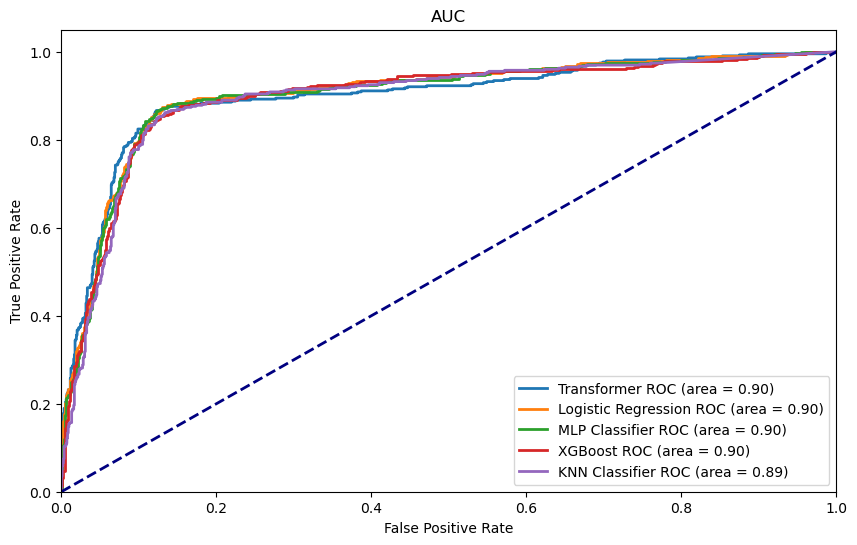

In [647]:
models = [
    ('Logistic Regression', LogisticRegression(C=8.68511373751352, penalty='l2', solver='saga', random_state=42)),
    ('MLP Classifier', MLPClassifier(max_iter= 250, learning_rate_init=0.01, solver='sgd', learning_rate= 'adaptive', hidden_layer_sizes=(30,), batch_size=143, alpha=0.3593813663804629, activation='tanh', random_state=42)), 
    ('XGBoost',XGBClassifier(random_state=19, objective='binary:logistic', eval_metric='logloss',subsample = 1.0, n_estimators=350, min_child_weight=5, max_depth=15, learning_rate=0.01)),
    ('KNN Classifier', KNeighborsClassifier(weights= 'distance', p=2, n_neighbors= 25, algorithm= 'auto')), 
]

plt.figure(figsize=(10, 6))

plt.plot(fpr_transformer, tpr_transformer, lw=2, label='Transformer ROC (area = %0.2f)' % roc_auc_transformer)

for name, model in models:
    pipeline = ImbPipeline([('model', model)])
    
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=19)

    y_probas = cross_val_predict(pipeline, X_combined_tfidf_val, y_val, cv=stratified_kfold, method='predict_proba')
    fpr, tpr, thresholds = roc_curve(y_val, y_probas[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label='%s ROC (area = %0.2f)' % (name, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC')
plt.legend(loc="lower right")
plt.show()

### Table with  model's resuslts

In [648]:
models = pd.DataFrame({'Model': ['Logistic Regression', 'KNN Classifier', 'MLP Classifier', 'XGBoost Classifier', 'DistilBERT'],
                       'F1 Score - validation': [f1_logit, f1_knn, f1_mlp, f1_xgboost, f1_distilbert],
                       'Accuracy Score - validation': [accuracy_logit, accuracy_knn, accuracy_mlp, accuracy_xgboost, accuracy_distilbert],
                       'ROC-AUC Score - validation': [roc_logit, roc_knn, roc_mlp, roc_xgboost, roc_distilbert],
                       'Precision Score - validation': [precision_logit, precision_knn, precision_mlp, precision_xgboost, precision_distilbert],
                       'Recall Score - validation': [recall_logit, recall_knn, recall_mlp, recall_xgboost, recall_distilbert]})
models.sort_values(by='F1 Score - validation', ascending=False)

,Model,F1 Score - validation,Accuracy Score - validation,ROC-AUC Score - validation,Precision Score - validation,Recall Score - validation
2,MLP Classifier,0.813288,0.895647,0.875603,0.795964,0.831382
0,Logistic Regression,0.807870,0.893726,0.869899,0.798627,0.817330
1,KNN Classifier,0.789934,0.877081,0.867210,0.741273,0.845433
4,DistilBERT,0.784897,0.879641,0.855824,0.767338,0.803279
3,XGBoost Classifier,0.780931,0.876440,0.854352,0.757709,0.805621


In [633]:
# Transform the Test data using the same vectorizers
X1_tfidf_test = tfidf_vectorizer1.transform(X1_test)
X2_tfidf_test = tfidf_vectorizer2.transform(X2_test)
X3_tfidf_test = tfidf_vectorizer3.transform(X3_test)

# Combine TF-IDF features for the validation data
X_combined_tfidf_test = hstack([X1_tfidf_test, X2_tfidf_test, X3_tfidf_test])

# Ensure that the number of features match
print(X_combined_tfidf_test.shape)  # Should output: (4686, 162797)

(695, 162797)


In [636]:
test_pred_array = mlp_model.predict(X_combined_tfidf_val)

In [639]:
test_pred = pd.Series(test_pred_array)
test_pred.to_csv('Test_predictions.csv', index=False)

In [641]:
test_pred.value_counts()

0    1116
1     446
Name: count, dtype: int64